In [12]:
#!conda install pytorch
#!conda install Pillow
#!conda install scikit-image
#conda install -c conda-forge opencv
#conda install -c conda-forge keras
#conda install -c conda-forge tensorflow

In [2]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import OneHotEncoder
import cv2
import PIL


Setting up GPU for caluculations

In [ ]:
#conda create --name tf_gpu tensorflow-gpu 

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
pysical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(pysical_devices))
tf.config.experimental.set_memory_growth(pysical_devices[0], True)

Num GPUs Available:  1


Converting the JSON file to a Pandas dataframe but dropping image 4215425.jpg as this was corrupted

In [5]:
# Load JSON: json_data
with open("dataset.json") as json_file:
    json_data = json.load(json_file)

# Create a list to hold the labels
labels = []

# Extract the image IDs and price categories
for item in json_data:
    try:
        if "price_category" in item and "more_details" in item and "full_images" in item["more_details"]:
            price_category = item["price_category"]["label"]
            images = item["more_details"]["full_images"]
            for image in images:
                image_id = image["image_id"]
                labels.append({"image_id": image_id, "price_category": price_category})
    except TypeError:
        continue

# Convert the labels list to a Pandas DataFrame
labels = pd.DataFrame(labels, index=None)

# Drop the row with image ID '4215425.jpg'
labels = labels.drop(labels.loc[labels['image_id'] == '4215425.jpg'].index)


In [17]:
labels.head()

,image_id,price_category
0,2088757,A moderate spend
1,2182000,A moderate spend
2,4151606,A moderate spend
3,4151588,A moderate spend
4,2224983,A moderate spend


In [6]:
train_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\train'
test_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\test'

In [7]:
train_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=train_path,target_size=(256,256),classes=['On a budget','Moderate spend','Special occasion','Spare no expense'],batch_size=10)
test_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path,target_size=(256,256),classes=['On a budget','Moderate spend','Special occasion','Spare no expense'],batch_size=10,shuffle=False)

Found 90100 images belonging to 4 classes.
Found 23276 images belonging to 4 classes.


In [40]:
train_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,validation_split=0.9)\
    .flow_from_directory(directory=train_path,target_size=(256,256),classes=['On a budget','Moderate spend','Special occasion','Spare no expense'],batch_size=10,sample_frac=0.1)
test_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,validation_split=0.9) \
    .flow_from_directory(directory=test_path,target_size=(256,256),classes=['On a budget','Moderate spend','Special occasion','Spare no expense'],batch_size=10,sample_frac=0.1,shuffle=False)

TypeError: flow_from_directory() got an unexpected keyword argument 'sample_frac'

In [8]:
imgs, labels = next(train_batch)

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

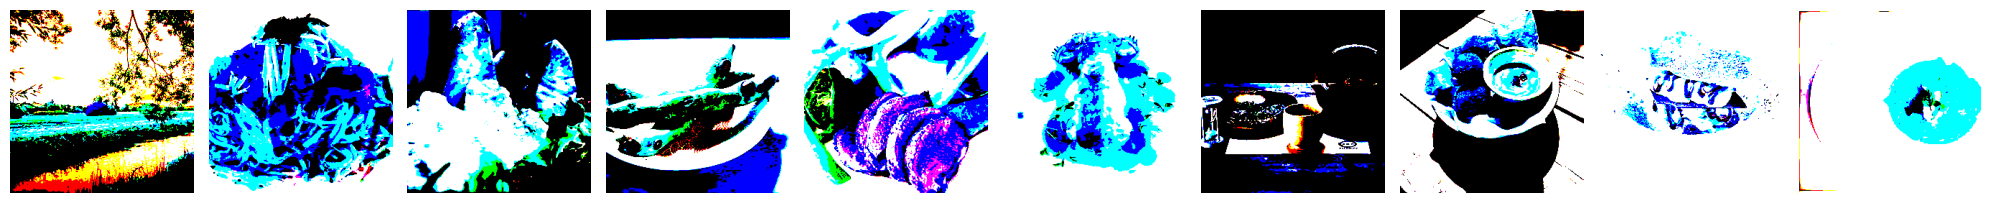

[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [10]:
plotImages(imgs)
print(labels)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16

# Load the VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))

# Freeze the VGG16 layers
for layer in vgg16.layers:
    layer.trainable = False

# Build a classifier on top of the VGG16 model
model = Sequential([
    vgg16,
    Flatten(),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_batch, epochs=3, validation_data=test_batch)


Epoch 1/3
4104/9010 [============>.................] - ETA: 4:26 - loss: 66.7248 - accuracy: 0.3823